# PUC Minas
## Prediçāo de Insuficiência Cardíaca
### Projeto Integrado – Inteligência Artificial e Aprendizado de Máquina

- **Autor**: Vinicio Silva Lima

Este notebook tem como objetivo apresentar todo o processo de desenvolvimento do modelo preditivo para a base de "Heart Failure Prediction Dataset" da plataforma [Kaggle](https://www.kaggle.com). A base pode ser encontrada por meio do seguinte [link](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from category_encoders.one_hot import OneHotEncoder

In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pio.templates.default = "simple_white"
light_gray = '#747678'
light_blue = '#1f77b4'
dark_blue = '#0C569F'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['figure.figsize'] = (18, 14)
mpl.rcParams['ytick.color'] = '#747678'
mpl.rcParams['xtick.color'] = '#747678'
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['yaxis.labellocation'] = 'top'
# mpl.rcParams['xaxis.labellocation'] = 'left'

### Lendo a base de dados

In [3]:
#Lendo csv
df = pd.read_csv('heart.csv')
#Verificando a quantidade de linhas, colunas, nulos e o tipo de cada varíavel
df.info()
##Verificando as 3 primeiras linhas do dataframe
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0


<p style="font-size:11pt;"> Podemos observar que nāo temos nenhuma variável com dados nulos. Apesar disso, vamos precisar categorizar essas variáveis em formato object para utilizar no modelo posteriormente.</p>

### Separando as variáveis númericas

In [4]:
#Selecionando as variáveis de formato numérico
atributos_numericos = df.select_dtypes(include=['int64', 'float64'])
#Verificando se as variáveis sāo numéricas
atributos_numericos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           918 non-null    int64  
 1   RestingBP     918 non-null    int64  
 2   Cholesterol   918 non-null    int64  
 3   FastingBS     918 non-null    int64  
 4   MaxHR         918 non-null    int64  
 5   Oldpeak       918 non-null    float64
 6   HeartDisease  918 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 50.3 KB


### Separando as variáveis em formato string e convertendo-as para formato categórico

In [5]:
#Selecionando as variáveis de formato object e transformando em categóricas
atributos_categoricos = df.select_dtypes(include=['object']).astype('category')
#Verificando se as variáveis sāo categóricas
atributos_categoricos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             918 non-null    category
 1   ChestPainType   918 non-null    category
 2   RestingECG      918 non-null    category
 3   ExerciseAngina  918 non-null    category
 4   ST_Slope        918 non-null    category
dtypes: category(5)
memory usage: 5.3 KB


### Aplicando métricas estatísticas de dispersāo para entender as variáveis numéricas

In [6]:
# métricas de tendência central
# transpor para facilitar a visualização
ct1 = pd.DataFrame(atributos_numericos.apply(np.mean)).T # média
ct2 = pd.DataFrame(atributos_numericos.apply(np.median)).T # mediana
# métricas de dispersão
d1 = pd.DataFrame(atributos_numericos.apply(np.std)).T # desvio-padrão
d2 = pd.DataFrame(atributos_numericos.apply(min)).T # mínimo
d3 = pd.DataFrame(atributos_numericos.apply(max)).T # máximo
d4 = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T # assimetria
d6 = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T # curtose
# concatenar as métricas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() # métricas
# nomear as colunas dos atributos concatenados
m.columns = ['Atributos' , 'Min', 'Max', 'Range', 'Média', 'Mediana', 'Desvio-Padrão', 'Assimetria',
           'Curtose']
#Mostra tabela com os resultados
m

,Atributos,Min,Max,Range,Média,Mediana,Desvio-Padrão,Assimetria,Curtose
0,Age,28.00,77.00,49.00,53.51,54.00,9.43,-0.20,-0.39
1,RestingBP,0.00,200.00,200.00,132.40,130.00,18.50,0.18,3.27
2,Cholesterol,0.00,603.00,603.00,198.80,223.00,109.32,-0.61,0.12
3,FastingBS,0.00,1.00,1.00,0.23,0.00,0.42,1.26,-0.40
4,MaxHR,60.00,202.00,142.00,136.81,138.00,25.45,-0.14,-0.45
5,Oldpeak,-2.60,6.20,8.80,0.89,0.60,1.07,1.02,1.20
6,HeartDisease,0.00,1.00,1.00,0.55,1.00,0.50,-0.22,-1.96


<p style="font-size:11pt;"> Podemos perceber que a variável de Cholesterol possui valores zerados e um desvio-padrāo considerável. A variável de Oldpeak está apresentando valores negativos, entāo será necessário entender se esses valores sāo válidos.</p>

### Filtrando as colunas numéricas e entendendo um pouco a distribuíçāo por quartil das variáveis

In [7]:
#Entendendo as variáveis numéricas
df.describe(include=['float64', 'int64'], percentiles=[0.01, .1, .25, .50, .75, .9, .99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Age,918.00,53.51,9.43,28.00,32.00,40.00,47.00,54.00,60.00,65.00,74.00,77.00
RestingBP,918.00,132.40,18.51,0.00,95.00,110.00,120.00,130.00,140.00,160.00,180.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,0.00,0.00,173.25,223.00,267.00,305.00,411.49,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
MaxHR,918.00,136.81,25.46,60.00,77.17,103.00,120.00,138.00,156.00,170.00,186.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,-0.50,0.00,0.00,0.60,1.50,2.30,4.00,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00


<p style="font-size:11pt;"> Podemos observar que a variável de Cholesterol provavelmente possui outliers, já que o valor máximo apresentado se difere muito em relaçāo a média.</p>

### Concatenando os dados categoricos e numéricos

In [8]:
#Juntando as bases das variáveis númericas e categóricas
df = pd.concat([atributos_categoricos, atributos_numericos], axis=1)
#Verificando as 3 primeiras linhas do dataframe
df.head(3)

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,M,ATA,Normal,N,Up,40,140,289,0,172,0.00,0
1,F,NAP,Normal,N,Flat,49,160,180,0,156,1.00,1
2,M,ATA,ST,N,Up,37,130,283,0,98,0.00,0


### Filtrando colunas categoricas e aplicando o OneHotEncoder para classifica-las numericamente

In [9]:
#Filtrando as colunas categoricas
cols_encoding = df.select_dtypes(include='category').columns
#Passando para o OneHotEncoder as colunas categoricas
ohe = OneHotEncoder(cols=cols_encoding)
#Quebrando as variáveis categóricas em colunas númericas
encoded = ohe.fit_transform(df)
#Verificando as 3 primeiras linhas do dataframe
encoded.head(3)

,Sex_1,Sex_2,ChestPainType_1,ChestPainType_2,ChestPainType_3,ChestPainType_4,RestingECG_1,RestingECG_2,RestingECG_3,ExerciseAngina_1,ExerciseAngina_2,ST_Slope_1,ST_Slope_2,ST_Slope_3,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,40,140,289,0,172,0.00,0
1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,49,160,180,0,156,1.00,1
2,1,0,1,0,0,0,0,1,0,1,0,1,0,0,37,130,283,0,98,0.00,0


### Distribuiçāo das colunas categoricas

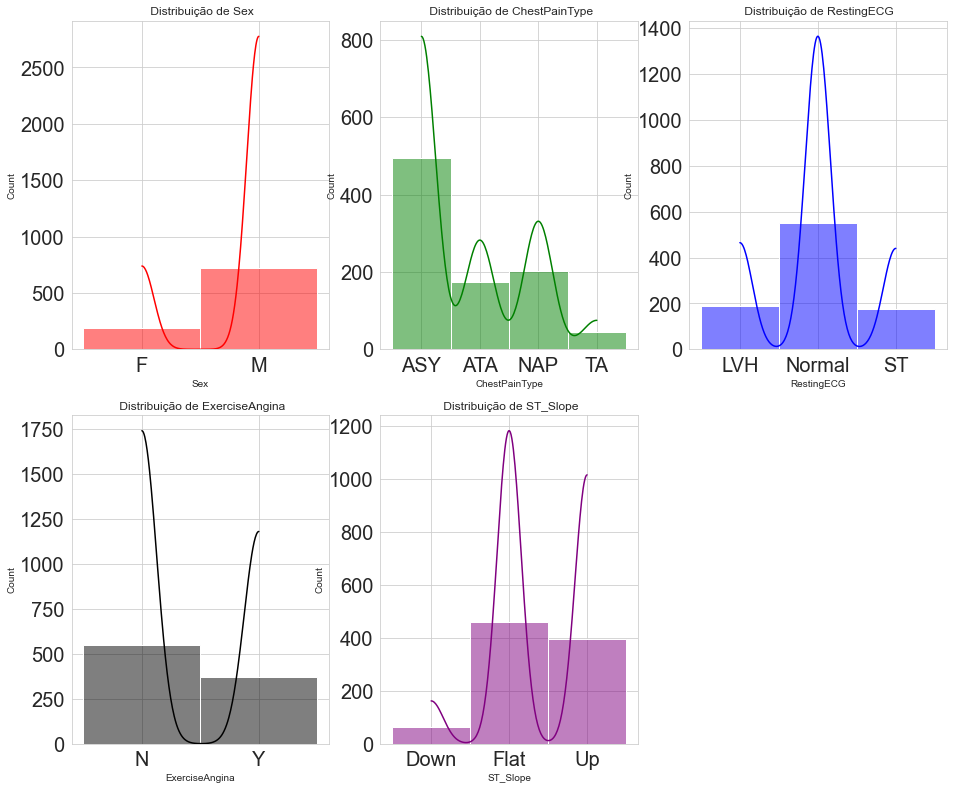

In [59]:
atr_cat = (atributos_categoricos.dtypes == "category")
atr_cat_list = [x for x in list(atr_cat[atr_cat].index)]
numerical_colors = ['red', 'green', 'blue', 'black', 'purple']

for i in range(len(atr_cat_list)):
    class_name = atr_cat_list[i]
    plt.subplot(4,3,i+1)
    sns.histplot(df[class_name], color=numerical_colors[i%len(numerical_colors)], kde=True).set_title(f' Distribuiçāo de {class_name}')
plt.subplots_adjust(bottom=1, right=0.8, top=2.5)

### Distribuiçāo das colunas numéricas

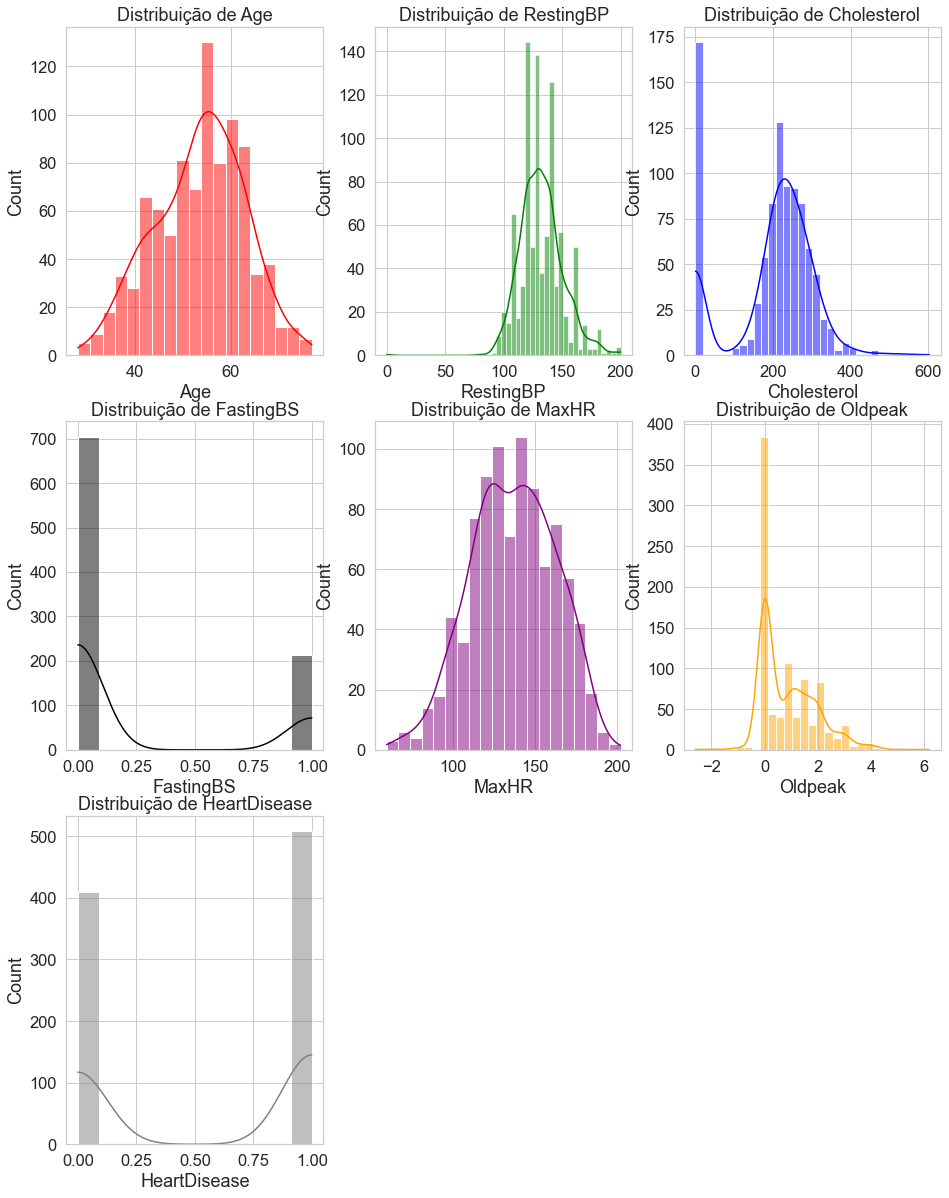

In [184]:
numerical = [x for x in list(atributos_numericos)]
numerical_colors = ['red', 'green', 'blue', 'black', 'purple', 'orange', 'grey']

for i in range(len(numerical)):
    class_name = numerical[i]
    plt.subplot(4,3,i+1)
    sns.histplot(df[class_name], color = numerical_colors[i%len(numerical_colors)], kde =True).set_title(f'Distribuiçāo de {class_name}')
plt.subplots_adjust(bottom=1, right=0.8, top=2.5)

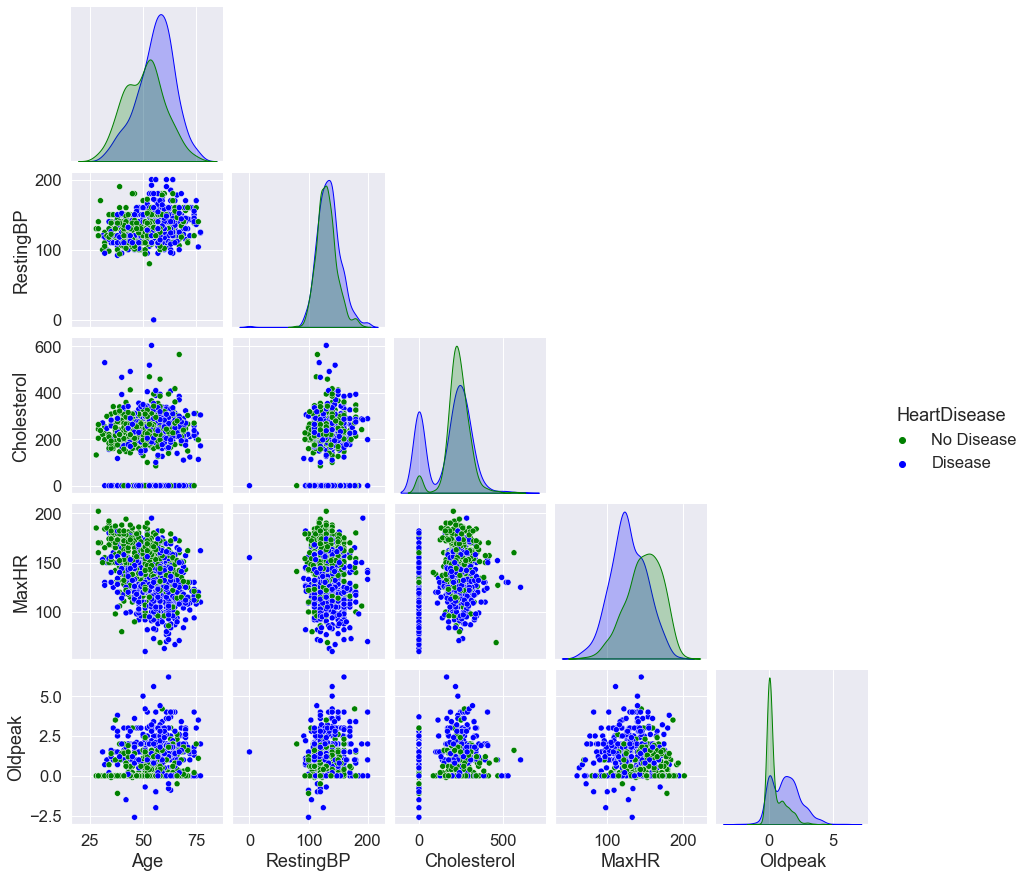

In [76]:
scatter_df = df.copy()
col = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
sns.set(font_scale=1.5)
scatter_df['HeartDisease'].rename({'0':'No Disease', '1':'Disease'})
scatter_df['HeartDisease']=scatter_df['HeartDisease'].map({0:'No Disease', 1:'Disease'})
img = sns.pairplot(vars=col, hue='HeartDisease', data=scatter_df , palette={'No Disease':'Green', 'Disease':'blue'}, corner=True, )
plt.show()

### Verificando outliers com boxplot

In [82]:
import plotly.express as px
cols_num = atributos_numericos[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].copy()
for col in cols_num:
    fig = px.box(atributos_numericos, y=col)
    fig.show()

### Testes de hipotese

In [148]:
from scipy.stats import kstest
from scipy import stats

cols_num = atributos_numericos[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].copy()
for col in cols_num:
    pvalue = kstest(df[col], stats.norm.cdf).pvalue

    print('-----------------------------------------------')
    print('Variável:', col)

    if pvalue < 0.05:
        print('p-value menor que 5%. Hipótese H0 rejeitada')
        print('Não possui distribuição normal')
    else:
        print('p-value menor que 5%. Hipótese H0 Aceita')
        print('Variável possui distribuição normal')

    print('P_value do teste:', pvalue)

-----------------------------------------------
Variável: Age
p-value menor que 5%. Hipótese H0 rejeitada
Não possui distribuição normal
P_value do teste: 0.0
-----------------------------------------------
Variável: RestingBP
p-value menor que 5%. Hipótese H0 rejeitada
Não possui distribuição normal
P_value do teste: 0.0
-----------------------------------------------
Variável: Cholesterol
p-value menor que 5%. Hipótese H0 rejeitada
Não possui distribuição normal
P_value do teste: 0.0
-----------------------------------------------
Variável: MaxHR
p-value menor que 5%. Hipótese H0 rejeitada
Não possui distribuição normal
P_value do teste: 0.0
-----------------------------------------------
Variável: Oldpeak
p-value menor que 5%. Hipótese H0 rejeitada
Não possui distribuição normal
P_value do teste: 4.2004655072318036e-200


In [149]:
from scipy.stats import mannwhitneyu

cols_num = atributos_numericos[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].copy()
col_target = df['HeartDisease'] == 1

for col in cols_num:
    
    positive_heart = df.loc[col_target, col]
    negative_heart = df.loc[~col_target, col]

    pvalue = mannwhitneyu(positive_heart, negative_heart).pvalue

    print('----------------------------------------')
    print('Variável:', col)    
    
    if pvalue < 0.05:
        print('Hipótese H0 rejeitada. Amostras diferentes')

    else:
        print('Hipótese H0 Aceita. Amostras similares')

    print('P_value do teste:', pvalue)

----------------------------------------
Variável: Age
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 9.028470695146226e-19
----------------------------------------
Variável: RestingBP
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 0.00028240377468607676
----------------------------------------
Variável: Cholesterol
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 1.1401561817724619e-05
----------------------------------------
Variável: MaxHR
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 7.531794359798869e-35
----------------------------------------
Variável: Oldpeak
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 3.383922521719396e-37


In [154]:
from scipy.stats import chi2_contingency

chi_accepted=list()
chi_rejected=list()
col_categ = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df_tratado = pd.get_dummies(df, columns=col_categ, prefix=col_categ, prefix_sep='@')
col_target = df_tratado['HeartDisease'] == 1
col_categ_bi = [col for col in df_tratado.columns if '@' in col]

for col in col_categ_bi:
    positive_heart = df_tratado.loc[col_target, col]
    negative_heart = df_tratado.loc[~col_target, col]
    
    ctab = pd.crosstab(df_tratado[col], df_tratado['HeartDisease'])
    _, p_value, _, _ = chi2_contingency(ctab)
    
    print('----------------------------------------')
    print('Variável:', col)   
    
    if p_value < 0.05:
        chi_accepted.append(col)
        print('Hipótese H0 rejeitada. Amostras diferentes')
    else:
        chi_rejected.append(col) 
        print('Hipótese H0 aceita. Amostras similares')

    print('P_value do teste:', p_value)    
        

----------------------------------------
Variável: Sex@F
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 4.5976174508091984e-20
----------------------------------------
Variável: Sex@M
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 4.597617450809164e-20
----------------------------------------
Variável: ChestPainType@ASY
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 8.629373889117524e-55
----------------------------------------
Variável: ChestPainType@ATA
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 1.1525973044710746e-33
----------------------------------------
Variável: ChestPainType@NAP
Hipótese H0 rejeitada. Amostras diferentes
P_value do teste: 1.8597575246926209e-10
----------------------------------------
Variável: ChestPainType@TA
Hipótese H0 aceita. Amostras similares
P_value do teste: 0.13157675122814316
----------------------------------------
Variável: RestingECG@LVH
Hipótese H0 aceita. Amostras similares
P_value do 

### Analise da correlaçāo das variáveis

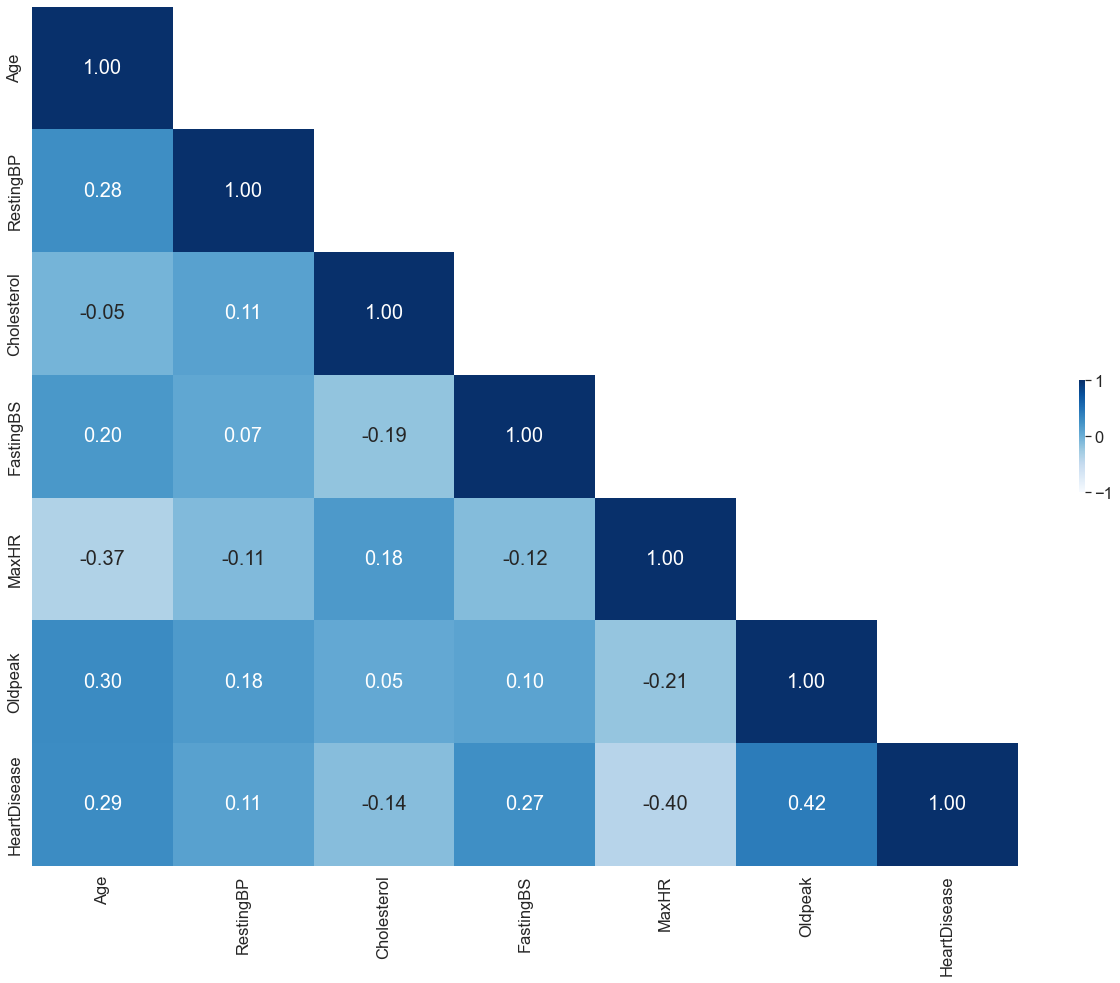

In [156]:
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
corr = df.corr(method='spearman')
mask = np.triu(corr, k=1).astype(bool)
heatmap_params = {
    'vmin': -1,
    'vmax': 1,
    'center': 0,
    'cbar_kws': {'shrink': .13},
    'annot_kws': {'size': 20},
    'mask': mask,
    'cmap': 'Blues',
    'annot': True,
    'fmt': '.2f',
}
fig, ax = plt.subplots()
sns.heatmap(corr, ax=ax, **heatmap_params)
ax.set_xticklabels(ax.get_yticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

### Verificando balanceamento

1    508
0    410
Name: HeartDisease, dtype: int64

Casos de parada cardiaca representam 55.34% do dataset.



/Users/viniciolima/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

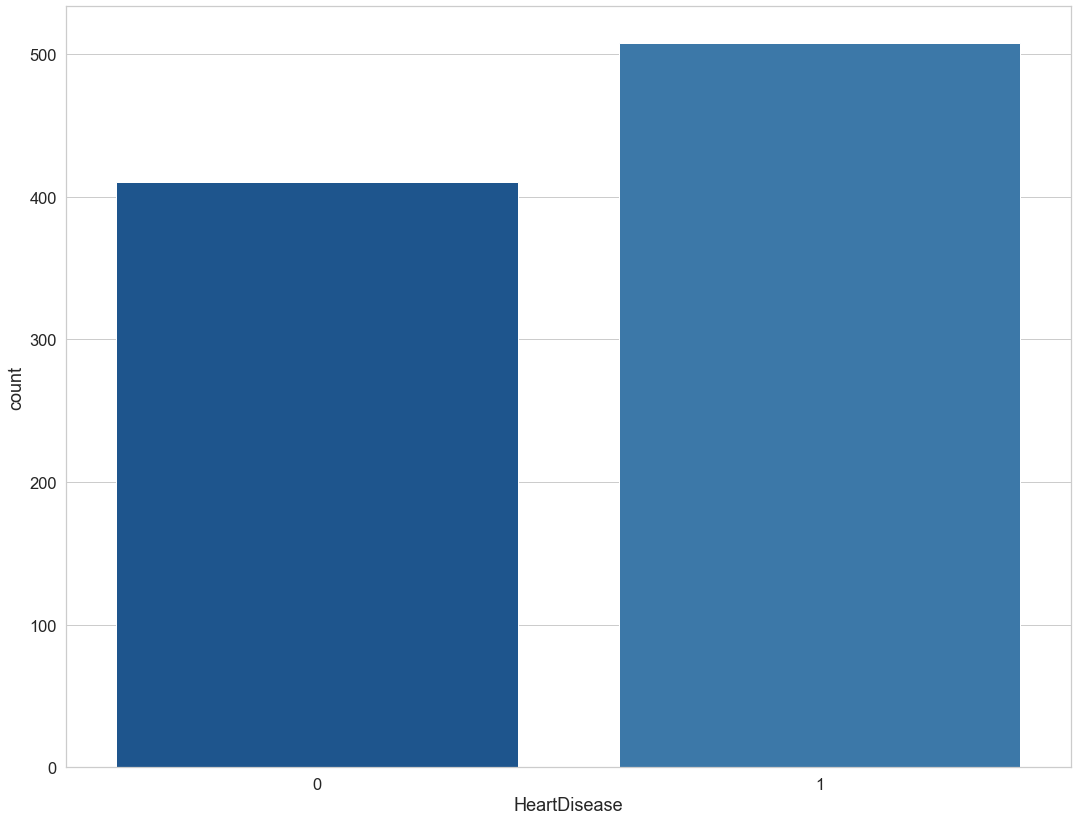

In [157]:
print(df.HeartDisease.value_counts())
print("\nCasos de parada cardiaca representam {:.2f}% do dataset.\n".format((df[df.HeartDisease == 1].shape[0] / df.shape[0]) * 100))
# plotar gráfico de barras para as Classes
sns.countplot('HeartDisease', data=df)

### Tratamento de outliers

In [178]:
def fill_median(df_x, df_y, col, median_normal=None, median_disease=None):
    df_median = pd.concat([df_x, df_y], axis=1)

    if (median_normal == None) & (median_disease == None):
        median_normal  = df_median.loc[(df_median[col]!=0) & 
                                       (df_median['HeartDisease']==0), col].median()
        median_disease = df_median.loc[(df_median[col]!=0) &
                                       (df_median['HeartDisease']==1), col].median()

    return (df_median.apply(lambda x : x[col] 
               if x[col] != 0 
               else median_normal 
                    if x['HeartDisease'] == 0 
                    else median_disease,
               axis=1), median_normal, median_disease)

### Separaçāo das variáveis de treino e teste

In [180]:
from sklearn.model_selection import train_test_split
X = encoded.drop(columns='HeartDisease')
y = encoded['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
X_train['Cholesterol'], median_normi_cholesterol, median_disease_cholesterol = fill_median(X_train, y_train, 'Cholesterol')

/var/folders/fk/d_4zs9dd5193w829sy4wrz840000gn/T/ipykernel_3155/1837330161.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

